# Reddit Sentiment Analysis

| Name       | Email address                 | Student ID  |
| ---------- | ----------------------------- | ----------- |
| Janik Rabe | svenjanik.rabe@post.idc.ac.il | 000 802 695 |
| Ben Terem  | ben.terem@post.idc.ac.il      | 309 981 512 |

In this project, we use NLTK's VADER sentiment analysis and Reddit comments from
[pushshift.io](http://files.pushshift.io/reddit/comments/) to analyze how sentiment
is correlated across subreddits.

We classify each subreddit as either serious (news, politics, etc.)
or casual (pictures, jokes, etc.).
Then, we investigate the correlation between pairs of subreddits and look into how
the classification (serious vs. casual) affects the strength of the correlation.
Our hypothesis is that all pairs of subreddits have some positive correlation,
but subreddits in the same group (serious or casual) are more strongly correlated.

We use an AWS EC2 instance to retrieve all comments from the year 2019 on six pre-selected
subreddits, three of each group.
As stated earlier, we use sentiment analysis to determine the sentiment of each comment.
After sampling and preparing our data, and plot and analyze distributions in our data.
We then compare the correlation between different pairs of subreddits by calculating their
mean squared error and Pearson correlation coefficients.
To check whether our results are statistically significant, we compute the $p$-values.
We train a simple linear regression model on the daily mean sentiments of serious vs.
casual subreddits.
Finally, we write a function for classifying a data point as being part of a serious or
casual subreddit based on its mean daily sentiment, using MLE.

We find that sentiment across subreddits in different groups often tends to be correlated,
but not for all pairs of subreddits and not as strongly as we thought initally.

<div style="background:#fed7d7;border-left:4px solid #c53030;margin:21px 0;padding:1rem;box-shadow:0 10px 15px -3px rgba(0,0,0,0.1), 0 4px 6px -2px rgba(0,0,0,0.05);color:#742a2a;border-radius:4px;">
    <p>
        <strong>Important:</strong>
        Before running the notebook, please download
        <a href="https://drive.google.com/file/d/1SzGptLU_780_u04uEP6Q1Jp0FXHeXvzN/view?hl=en"><code>data/sample.jsonl</code></a> (~3 GiB) and install the dependencies listed in the next cell.
    </p>
    <p>
        Please note that the sentiment analysis takes a long time to run (up to 2 hours on slow machines).
        If you would like to skip it, please comment out cell 6 and download the resulting
        <a href="https://drive.google.com/file/d/1-dPs2fYl2ZYatTJif61Ful8S3V5Y85az/view?hl=en"><code>data/sample.csv</code></a> (~410 MiB) directly instead.
    </p>
</div>

First, let's import some modules:

In [1]:
%matplotlib inline

import csv   # part of the standard library; no need to install
import json  # part of the standard library; no need to install
import os    # part of the standard library; no need to install
import sys   # part of the standard library; no need to install

import nltk                      # please install: nltk
import matplotlib.pyplot as plt  # please install: matplotlib
import pandas as pd              # please install: pandas
import numpy as np               # please install: numpy
import seaborn as sns            # please install: seaborn
import scipy                     # please install: scipy

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
if not nltk.download('vader_lexicon', quiet=True):
    print('Failed to download sentiment analysis lexicon', file=sys.stderr)

In [3]:
os.makedirs('data', exist_ok=True)

In [4]:
has_jsonl = os.path.exists('data/sample.jsonl') # input to sentiment analysis (contains full comments)
has_csv   = os.path.exists('data/sample.csv')   # output of sentiment analysis (contains sentiment values)

if has_jsonl:
    if has_csv: print('Found both files; notebook will run (even if you comment out the sentiment analysis).')
    else:       print('Found JSONL only; notebook will run (but you will NOT be able to comment out the sentiment analysis).');
else:
    if has_csv: print('Warning: Found CSV only; sentiment analysis must be commented out.', file=sys.stderr)
    else:       raise RuntimeError('Please download `data/sample.jsonl`; see the red box above for more information.')

Found both files; notebook will run (even if you comment out the sentiment analysis).


## Preprocessing

We began by downloading all Reddit comments from the year 2019 from [pushshift.io](http://files.pushshift.io/reddit/comments/).

The raw data from pushshift.io consisted of terabytes of uncompressed comments.
We ran the following script on an AWS instance to preprocess the data.
This script removes unnecessary metadata and keeps only comments on the following subreddits:

- r/AskReddit (<span style="color:blue">casual</span>)
- r/pics (<span style="color:blue">casual</span>)
- r/funny (<span style="color:blue">casual</span>)
- r/politics (<span style="color:red">serious</span>)
- r/news (<span style="color:red">serious</span>)
- r/worldnews (<span style="color:red">serious</span>)

```sh
#!/bin/sh
for file
do
	pv < "$file" |
		zstd -d |
		parallel --pipe --group --block 10M --recend '\n' \
			jq -c "'select (.subreddit | match(\"(?i)\\\\A(askreddit|pics|funny|politics|news|worldnews)\\\\z\")) | { body, created_utc, score, subreddit }'" |
		zstd > "$file.filtered.zst"

	rm -- "$file"
done

zstdcat *.filtered.zst | zstd > combined.jsonl.zst
```

The resulting file contains about 146.6 million comments and, without compression, would be almost 30 gibibytes in size.

We sampled 10% of the data to speed up the process and make the data easier to work with.

```sh
pv < combined.jsonl.zst | zstd -d | awk 'NR % 10 == 0' > sample.jsonl
```

## Sentiment Analysis

The dataset contains the actual comments, but we're only interested in their sentiment values.

We'll use NLTK's VADER to convert comments into sentiment values ranging from -1 (very negative) to 1 (very positive).

### What is Sentiment Analysis?

[Techopedia](https://www.techopedia.com/definition/29695/sentiment-analysis) defines sentiment analysis as follows:

> Sentiment analysis uses data mining processes and techniques to extract and capture data for analysis in order to discern the subjective opinion of a document or collection of documents, like blog posts, reviews, news articles and social media feeds like tweets and status updates.
> Sentiment analysis allows organizations to track the following:
>
> - Brand reception and popularity
> - New product perception and anticipation
> - Company reputation
> - Flame/rant detection

We'll parse the `sample.jsonl` file, run NLTK's sentiment analysis, and write the results to `sample.csv`.

In [5]:
def run_sentiment_analysis():
    sid = SentimentIntensityAnalyzer()

    with open('data/sample.csv.tmp', 'w', newline='') as cf:
        cw = csv.writer(cf, quoting=csv.QUOTE_MINIMAL)
        cw.writerow(['date', 'subreddit', 'score', 'sentiment'])

        with open('data/sample.jsonl', 'rb') as f:
            while True:
                line = f.readline()

                if not line:
                    break

                obj = json.loads(line)

                sentiment = sid.polarity_scores(obj['body'])['compound']
                cw.writerow([obj['created_utc'], obj['subreddit'], obj['score'], sentiment])

    if os.path.exists('data/sample.csv'):
        os.remove('data/sample.csv')

    os.rename('data/sample.csv.tmp', 'data/sample.csv')

In [6]:
%%time

# Note: `run_sentiment_analysis` reads `data/sample.jsonl` and writes `data/sample.csv`.
# Please comment it out if you downloaded `data/sample.csv` but not `data/sample.jsonl`.
run_sentiment_analysis()

CPU times: user 57min 22s, sys: 23.9 s, total: 57min 46s
Wall time: 57min 47s


Next, we'll parse the file we just created.
Storing this data allows us to load the file without running the entire sentiment analysis again.

In [7]:
df = pd.read_csv('data/sample.csv')

Let's take a look at our data:

In [8]:
df

,date,subreddit,score,sentiment
0,1546300801,AskReddit,3,0.9707
1,1546300803,AskReddit,-6,0.0000
2,1546300805,funny,1,-0.3515
3,1546300807,politics,1,-0.2500
4,1546300811,funny,1,0.2263
...,...,...,...,...
14664502,1577836745,AskReddit,1,0.0000
14664503,1577836746,AskReddit,3,0.7351
14664504,1577836748,AskReddit,2,0.7717
14664505,1577836750,AskReddit,2,0.0000


## Data Preparation

The original data contains a UNIX timestamp in the `date` column.
We'll first convert it into a Python [`datetime`](https://docs.python.org/3/library/datetime.html#datetime.datetime) object.
However, we're only interested in the date (without time), so we'll convert the [`datetime`](https://docs.python.org/3/library/datetime.html#datetime.datetime) into a [`date`](https://docs.python.org/3/library/datetime.html#date-objects) object.

In [9]:
%%time

df['date'] = pd.to_datetime(df['date'], unit='s')
df['date'] = df['date'].dt.date

CPU times: user 3.97 s, sys: 580 ms, total: 4.55 s
Wall time: 4.55 s


In [10]:
df

,date,subreddit,score,sentiment
0,2019-01-01,AskReddit,3,0.9707
1,2019-01-01,AskReddit,-6,0.0000
2,2019-01-01,funny,1,-0.3515
3,2019-01-01,politics,1,-0.2500
4,2019-01-01,funny,1,0.2263
...,...,...,...,...
14664502,2019-12-31,AskReddit,1,0.0000
14664503,2019-12-31,AskReddit,3,0.7351
14664504,2019-12-31,AskReddit,2,0.7717
14664505,2019-12-31,AskReddit,2,0.0000


Since we're comparing serious to more casual subreddits, we need to classify our data accordingly.

In [11]:
serious_subreddits = ['politics', 'news', 'worldnews']
casual_subreddits = ['AskReddit', 'pics', 'funny']

subreddits = serious_subreddits + casual_subreddits
subreddit_colors = ['r'] * len(serious_subreddits) + ['b'] * len(casual_subreddits)

After evaluating different weight functions based on comment scores, we
found that assigning equal weights to all comments gave us the best results.
Other weight functions we tried were $e^x$, $\ln(x)$ with zero weights for negative scores,
and $\left(\frac{2 \tan^{-1}(x-1)}{\pi} + 1\right)^2$, where $x$ is the comment's score.

However, we decided to discard comments with non-positive scores.
The default score of Reddit comments is 1, so comments with more downvotes
than upvotes were discarded.
The majority of people seemed to disagree with these comments, so it doesn't
make much sense for them to influence the overall sentiment of the subreddit
as much as other comments.
Downvoted comments are also often off-topic or spam and not representative of
the subreddit's sentiment.

In [12]:
%%time

df.drop(df[df['score'] < 1].index, inplace=True)

CPU times: user 2.03 s, sys: 984 ms, total: 3.01 s
Wall time: 3.02 s


Now, let's group the comments by date and subreddit and
find the mean sentiment within each `(date, subreddit)` pair.

In [13]:
%%time

df_agg = df.groupby(['date', 'subreddit']).agg(np.mean).reset_index()

CPU times: user 2.08 s, sys: 480 ms, total: 2.56 s
Wall time: 2.56 s


In [14]:
df_agg

,date,subreddit,score,sentiment
0,2019-01-01,AskReddit,20.826056,0.079568
1,2019-01-01,funny,13.411449,0.003978
2,2019-01-01,news,16.743180,-0.064985
3,2019-01-01,pics,21.362856,0.126042
4,2019-01-01,politics,11.066667,0.002223
...,...,...,...,...
2185,2019-12-31,funny,15.507340,0.040550
2186,2019-12-31,news,18.610556,-0.084625
2187,2019-12-31,pics,18.351284,0.077029
2188,2019-12-31,politics,10.927988,0.003934


## Data Exploration

Let's draw a few plots to help us better understand the data.

### Score vs. Sentiment

Let's investigate whether the number of upvotes of a comment is correlated with its sentiment.

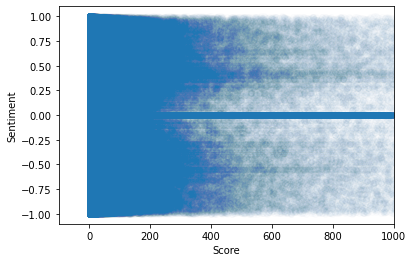

In [15]:
plt.scatter('score', 'sentiment', data=df, alpha=0.01)
plt.xlim(-100, 1000)
plt.xlabel('Score')
plt.ylabel('Sentiment')
plt.show();

Based on this graph, there doesn't seem to be a strong correlation between the two values.
(There is in fact a weak positive correlation, but because this is not directly related to our project, we won't go into detail here.)

Let's use seaborn to get a better idea of how the data is distributed.

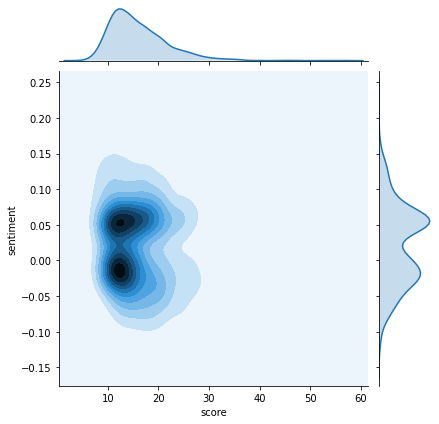

In [16]:
sns.jointplot(x='score', y='sentiment', data=df_agg, kind='kde');

We can see that there are two clusters, separated primarily by their mean sentiment.

### Sentiment over Time

Let's take a look at the sentiment over time for each of the six subreddits.

We show serious subreddits in red and casual subreddits in blue.

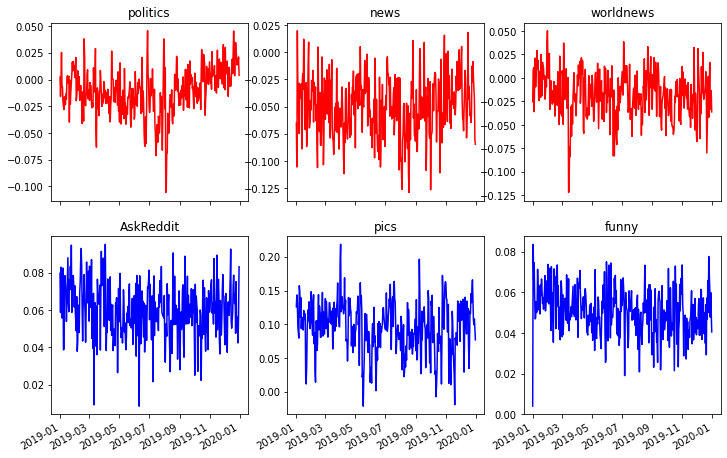

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for (i, group) in enumerate([serious_subreddits, casual_subreddits]):
    for (j, subreddit) in enumerate(group):
        xs = df_agg[df_agg['subreddit'] == subreddit]
        ax = axes[i, j]
        ax.set_title(subreddit)
        ax.plot(xs['date'], xs['sentiment'].to_numpy(), color='r' if i == 0 else 'b')

fig.autofmt_xdate()

Note how the mean sentiment appears to be more positive in casual subreddits than in more serious ones—let's explore that further.

### Mean Sentiment by Subreddit

To confirm that casual subreddits indeed have a higher mean sentiment,
we'll plot the mean sentiment for each subreddit.

The black vertical lines show two standard deviations above and below the
mean, which corresponds roughly to the 95% confidence interval.

$$
\delta = \sqrt{\frac{\sigma^2}{N}}
$$

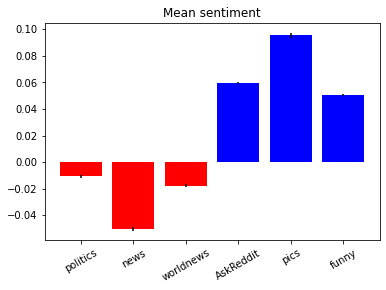

In [18]:
def mean_sentiment(sn):
    return df_agg[df_agg['subreddit'] == sn]['sentiment'].mean()

def two_std_sentiment(sn):
    dd = df_agg[df_agg['subreddit'] == sn]['sentiment']
    std = dd.std(ddof=1)
    
    return np.sqrt(std**2 / dd.shape[0])

plt.bar(
    subreddits,
    [mean_sentiment(s) for s in subreddits],
    yerr=[two_std_sentiment(s) for s in subreddits],
    color=subreddit_colors)
plt.xticks(rotation=30)
plt.title('Mean sentiment');

This plot confirms that comments in more casual subreddits tend to be more positive than comments in serious subreddits.

## Mean Squared Error

To compare differences in sentiments across subreddits over time, let's compute the Mean Squared Error (MSE).
The `mse` function simply computes the difference between the mean sentiments of two subreddits for each day of the year, squares them, and then finds the mean of the resulting values.

$$
\frac{\Sigma_{i=1}^{d} {\left(A_i - B_i\right)}^2}{d}
$$

In our case, $d = 365$ because we have one row for each day of the year.

In [19]:
def mse(sn1, sn2):
    s1 = df_agg[df_agg['subreddit'] == sn1]['sentiment'].to_numpy()
    s2 = df_agg[df_agg['subreddit'] == sn2]['sentiment'].to_numpy()
    
    return ((s1 - s2)**2).mean()

Let us plot the MSEs for every possible combination of subreddits.

Our hypothesis is that subreddits within the same group (serious or casual) are more
closely correlated, but that there is also a positive correlation with subreddits in
the other group.

Again, serious subreddits are shown in red, while casual ones are shown in blue.

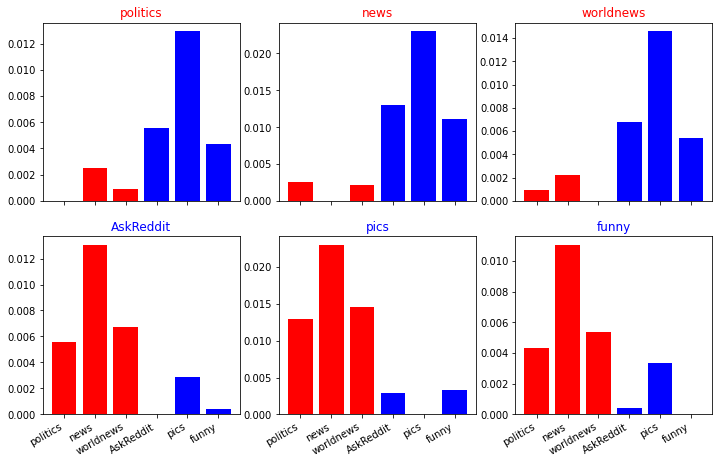

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for (i, group) in enumerate([serious_subreddits, casual_subreddits]):
    for (j, subreddit) in enumerate(group):
        ax = axes[i, j]
        ax.set_title(subreddit, color='r' if i == 0 else 'b')
        ax.bar(subreddits, [mse(s, subreddit) for s in subreddits], color=subreddit_colors)

fig.autofmt_xdate()

These graphs are encouraging, but some of the MSEs are quite large.
We cannot tell from these plots whether the correlation between these subreddits is statistically significant.

While the correlation of two subreddits in the same group certainly seems stronger than the correlation of two subreddits in different groups, we'll compute the $p$-values later on to check which of these results are statistically significant.

## Pearson Correlation Coefficient

So far we've only looked at the difference between subreddits,
but we haven't investigated whether they are positively or negatively
correlated.

To verify our hypothesis, let's compute the Pearson coefficient for each
pair of subreddits.
While the Pearson coefficient only measures linear relationships, it
can nevertheless give us a good idea of how different subreddits are
correlated.

$$
r = \frac{\Sigma_{i=1}^{N} \left((A_i - \hat{A}) (B_i - \hat{B})\right)}{\sqrt{(\Sigma_{i=1}^{N} ((A_i - \hat{A})^2)) (\Sigma_{i=1}^{N} ((B_i - \hat{B})^2))}}
$$

Although scipy provides the [`scipy.stats.pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) function, we chose to implement it ourselves here, based on the formula above.

In [21]:
def pearson(sn1, sn2):
    s1 = df_agg[df_agg['subreddit'] == sn1]['sentiment'].to_numpy()
    s2 = df_agg[df_agg['subreddit'] == sn2]['sentiment'].to_numpy()
    
    num = ((s1 - s1.mean()) * (s2 - s2.mean())).sum()
    den = np.sqrt((((s1 - s1.mean())**2).sum() * (((s2 - s2.mean())**2).sum())))
    
    return num / den

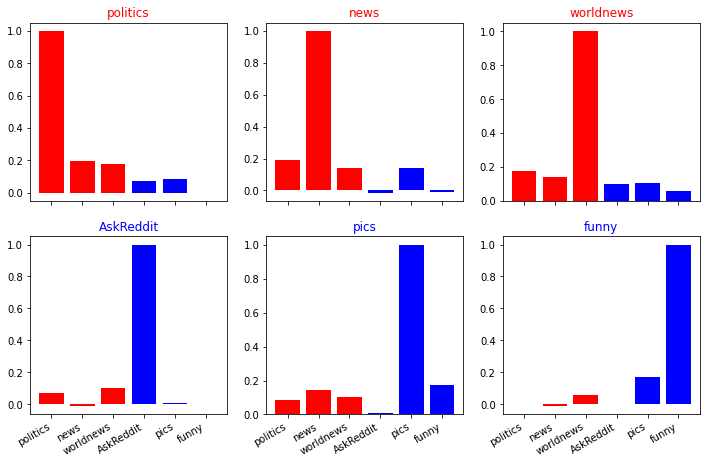

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for (i, group) in enumerate([serious_subreddits, casual_subreddits]):
    for (j, subreddit) in enumerate(group):
        ax = axes[i, j]
        ax.set_title(subreddit, color='r' if i == 0 else 'b')
        ax.bar(subreddits, [pearson(s, subreddit) for s in subreddits], color=subreddit_colors)

fig.autofmt_xdate()

As expected, the correlation of any subreddit with itself is 1.
However, not all pairs of subreddits appear to be strongly positively correlated; in fact,
some of the Pearson coefficients are (very slightly) negative.

In [23]:
pearson('AskReddit', 'news')

-0.014003486966027894

We're guessing that these negative correlations are not statistically significant,
but we need to verify that.

## Statistical Significance

We'll compute the $p$-values to check which of the correlations are significant.

In [24]:
def p_value(sn1, sn2):
    s1 = df_agg[df_agg['subreddit'] == sn1]['sentiment'].to_numpy()
    s2 = df_agg[df_agg['subreddit'] == sn2]['sentiment'].to_numpy()
    
    _, p_value = scipy.stats.pearsonr(s1, s2)
    
    return p_value

Let's plot the $p$-value for each pair of subreddits.

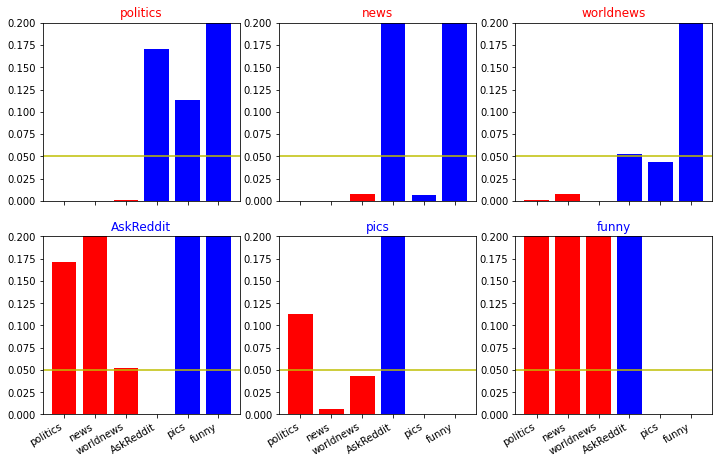

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for (i, group) in enumerate([serious_subreddits, casual_subreddits]):
    for (j, subreddit) in enumerate(group):
        ax = axes[i, j]
        ax.set_title(subreddit, color='r' if i == 0 else 'b')
        ax.bar(subreddits, [p_value(s, subreddit) for s in subreddits], color=subreddit_colors)
        ax.axhline(0.05, color='y')
        ax.set_ylim(0, 0.2)

fig.autofmt_xdate()

$p$-values of less than 0.05 are generally regarded as statistically significant;
the yellow line shows this value on the plots.

We can see that, while many of the correlations are significant, a number of them are not.

Unsurprisingly, correlations within the same group (serious or casual) tend to be statistically significant.
However, AskReddit does not have any statistically significant correlations with other subreddits,
not even other casual subreddits.
This surprised us, as we expected some correlation between all pairs of subreddits.

## Linear Regression

Let's try to find a linear model corresponding to the correlation between serious and casual subreddits on a given day.

First, we'll add a `group` column that is `c` for casual and `s` for serious subreddits.

In [26]:
df_agg.loc[df_agg['subreddit'] == 'AskReddit', 'group'] = 'c'
df_agg.loc[df_agg['subreddit'] == 'pics',      'group'] = 'c'
df_agg.loc[df_agg['subreddit'] == 'funny',     'group'] = 'c'
df_agg.loc[df_agg['subreddit'] == 'politics',  'group'] = 's'
df_agg.loc[df_agg['subreddit'] == 'news',      'group'] = 's'
df_agg.loc[df_agg['subreddit'] == 'worldnews', 'group'] = 's'

We use seaborn to plot the data while simultaneously finding the linear model.

In [27]:
daily_sentiment_s = df_agg[df_agg['group'] == 's'].groupby('date').agg(np.mean)['sentiment']
daily_sentiment_c = df_agg[df_agg['group'] == 'c'].groupby('date').agg(np.mean)['sentiment']

daily_sentiment_by_group = pd.DataFrame()
daily_sentiment_by_group['serious'] = daily_sentiment_s.to_numpy()
daily_sentiment_by_group['casual'] = daily_sentiment_c.to_numpy()

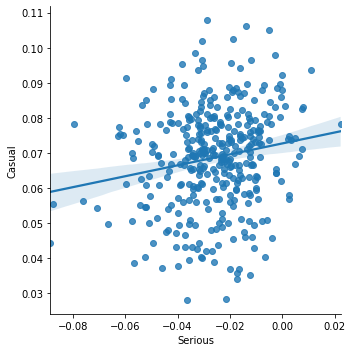

In [28]:
sns.lmplot(
    x='serious',
    y='casual',
    data=daily_sentiment_by_group,
).set_axis_labels('Serious', 'Casual');

As we can see, the correlation is small and the data is spread out.
However, we can verify that there is indeed a linear relationship:

In [29]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    x=daily_sentiment_s,
    y=daily_sentiment_c,
)

In [30]:
p_value

0.0007526862192448538

This $p$-value is far below the required value of 0.05, so there is certainly a statistically significant correlation.

In [31]:
r_value

0.17560447339417615

This $r$-value shows that the correlation is positive.

In [32]:
std_err

0.04598700145265262

This value is expected given how weak the correlation is.

## Subreddit Classification

We'll assume that daily mean sentiments are distributed normally.
Let's find the parameters of the normal distributions.

In [33]:
s_norm_param = (daily_sentiment_s.mean(), daily_sentiment_s.std()) # s = serious
c_norm_param = (daily_sentiment_c.mean(), daily_sentiment_c.std()) # c = casual

Let's plot the normal distribution together with a histogram of the data.

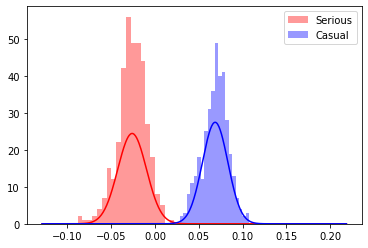

In [34]:
x = np.linspace(df_agg['sentiment'].min(), df_agg['sentiment'].max(), 500)

plt.hist(daily_sentiment_s, bins=20, alpha=0.4, color='r', label='Serious')
plt.hist(daily_sentiment_c, bins=20, alpha=0.4, color='b', label='Casual')
plt.plot(x, scipy.stats.norm.pdf(x, *s_norm_param), color='r')
plt.plot(x, scipy.stats.norm.pdf(x, *c_norm_param), color='b')
plt.legend();

It looks like the data isn't normally distributed (we have more data around
the mean than we could with the normal distribution we found); however, this
won't be a problem for our use case.

Let's create variables for the normal distributions:

In [35]:
s_norm = scipy.stats.norm(*s_norm_param) # s = serious
c_norm = scipy.stats.norm(*c_norm_param) # c = casual

Evaluate the probability density functions for mean sentiment 0.015.

In [36]:
point = 0.05

print("serious:", s_norm.pdf(point))
print("casual: ", c_norm.pdf(point))

serious: 0.0004612534095193975
casual:  12.09541082118222


We can see that the value of the PDF for serious subreddits
is much greater at the point we're evaluating than the PDF for
casual subreddits.
Hence, this mean sentiment is significantly more likely to belong
to a serious subreddit.

Now, we can classify data from a given day as serious or casual based on the mean sentiment.

In [37]:
def classify(p):
    s_pdf = s_norm.pdf(p)
    c_pdf = c_norm.pdf(p)
    
    s_prob = s_pdf / (s_pdf + c_pdf)
    
    if s_pdf > c_pdf:
        c_class = 'serious'
        c_confidence = s_prob
    else:
        c_class = 'casual'
        c_confidence = 1 - s_prob
    
    print("I'm ~{}% confident that the subreddit with mean daily sentiment {} is a {} subreddit.".format(
        round(100 * c_confidence, 3),
        round(p, 5),
        c_class,
    ))

In [38]:
classify(point)

I'm ~99.996% confident that the subreddit with mean daily sentiment 0.05 is a casual subreddit.


Because the overlap between the two normal curves is very small,
we can almost always classify points correctly.